-------------------------------------------------------------
SECTION 0 — IMPORT LIBRARIES
-------------------------------------------------------------

In [15]:
#                     SECTION 0 — IMPORT LIBRARIES
# -------------------------------------------------------------
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import joblib
import time
from scipy.ndimage import gaussian_filter
from skimage import feature as skf
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (train_test_split, GridSearchCV, cross_val_score )
from sklearn.metrics import ( accuracy_score, classification_report, confusion_matrix )
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA


-------------------------------------------------------------
SECTION 1 — LOAD & PREPROCESS IMAGES
-------------------------------------------------------------

In [16]:
#                SECTION 1 — LOAD & PREPROCESS IMAGES
# -------------------------------------------------------------

data_path = r"C:\Users\DELL\Desktop\indianflower"
img_size = 128

X_gray = []
X_color = []
y = []

for folder_name in os.listdir(data_path):
    folder_path = os.path.join(data_path, folder_name)

    if not os.path.isdir(folder_path):
        continue

    print("Loading Class:", folder_name)

    for file in os.listdir(folder_path):
        img_path = os.path.join(folder_path, file)

        img_color = cv2.imread(img_path)
        if img_color is None:
            continue

        img_color = cv2.resize(img_color, (img_size, img_size))

        img_gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)
        img_gray = gaussian_filter(img_gray, sigma=1)
        img_gray = cv2.equalizeHist(img_gray)

        X_gray.append(img_gray)
        X_color.append(img_color)
        y.append(folder_name)

X_gray = np.array(X_gray)
X_color = np.array(X_color)
y = np.array(y)

print("\nClasses Found:", np.unique(y))

print("\nTotal Images Loaded:", len(X_gray))
print("Classes Found:", np.unique(y))
print("Class Distribution:", Counter(y))

# After loading all images
unique_classes = np.unique(y)
num_classes = len(unique_classes)

print("\nTotal Images Loaded:", len(X_gray))
print("Total Number of Classes:", num_classes)
print("Classes Found:", unique_classes)







Loading Class: astilbe
Loading Class: bellflower
Loading Class: black_eyed_susan
Loading Class: Bougainvillea
Loading Class: Bright Eyes
Loading Class: calendula
Loading Class: california_poppy
Loading Class: carnation
Loading Class: Chandni
Loading Class: common_daisy
Loading Class: coreopsis
Loading Class: daffodil
Loading Class: dandelion
Loading Class: Dhalia
Loading Class: Hibiscus
Loading Class: iris
Loading Class: magnolia
Loading Class: Marigold
Loading Class: Pink Oleander
Loading Class: Rose
Loading Class: sunflower
Loading Class: Tecoma
Loading Class: tulip
Loading Class: water_lily

Classes Found: ['Bougainvillea' 'Bright Eyes' 'Chandni' 'Dhalia' 'Hibiscus' 'Marigold'
 'Pink Oleander' 'Rose' 'Tecoma' 'astilbe' 'bellflower' 'black_eyed_susan'
 'calendula' 'california_poppy' 'carnation' 'common_daisy' 'coreopsis'
 'daffodil' 'dandelion' 'iris' 'magnolia' 'sunflower' 'tulip' 'water_lily']

Total Images Loaded: 22953
Classes Found: ['Bougainvillea' 'Bright Eyes' 'Chandni' 'Dhal

-------------------------------------------------------------
SECTION 2 — TRAIN / TEST SPLIT
-------------------------------------------------------------

In [17]:
#    SECTION 2 — TRAIN / TEST SPLIT (Stratified)
# -------------------------------------------------------------

X_train_gray, X_test_gray, X_train_color, X_test_color, y_train, y_test = train_test_split(
    X_gray, X_color, y, test_size=0.2, random_state=42, stratify=y
)

print("Training Samples:", len(X_train_gray))
print("Testing Samples:", len(X_test_gray))


Training Samples: 18362
Testing Samples: 4591


-------------------------------------------------------------
SECTION 3 — VISUALIZE SAMPLE IMAGES
-------------------------------------------------------------

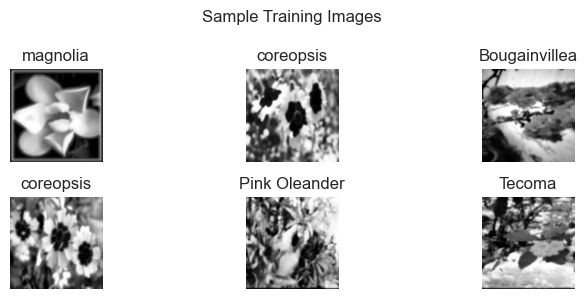

In [18]:
#         SECTION 3 — VISUALIZE SAMPLE TRAINING IMAGES
# -------------------------------------------------------------

plt.figure(figsize=(8, 3))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(X_train_gray[i], cmap='gray')
    plt.title(y_train[i])
    plt.axis('off')

plt.suptitle("Sample Training Images")
plt.tight_layout()
plt.show()


-------------------------------------------------------------
SECTION 4 — FEATURE EXTRACTION (Gabor + LBP + Color Features)
-------------------------------------------------------------

In [19]:
#     SECTION 4 — FEATURE EXTRACTION (Gabor + LBP + Color Features)
# ----------------------------------------------------------

def extract_features(gray_img, color_img):
    features = []

    # ----- GABOR FILTER FEATURES -----
    ksize = 15
    sigmas = [2, 3]
    thetas = [0, np.pi / 4, np.pi / 2, 3 * np.pi / 4]

    for sigma in sigmas:
        for theta in thetas:
            kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, 10.0, 0.5)
            filtered = cv2.filter2D(gray_img, cv2.CV_32F, kernel)
            features.append(filtered.mean())
            features.append(filtered.var())

    # ----- LBP FEATURES -----
    lbp = skf.local_binary_pattern(gray_img, 24, 3, method="uniform")
    hist_lbp, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 27), density=True)
    features.extend(hist_lbp)

    # ----- HSV COLOR HISTOGRAM -----
    hsv = cv2.cvtColor(color_img, cv2.COLOR_BGR2HSV)
    hist_hsv = cv2.calcHist([hsv], [0, 1, 2], None, [8, 8, 8], [0, 180, 0, 256, 0, 256])
    features.extend(hist_hsv.flatten())

    # ----- RGB MEAN & STD -----
    features.extend(color_img.mean(axis=(0, 1)))
    features.extend(color_img.std(axis=(0, 1)))

    # ----- COLOR MOMENTS -----
    for c in range(3):
        channel = color_img[:, :, c].astype(np.float32)
        m = channel.mean()
        v = channel.var()
        s = np.mean((channel - m) ** 3)
        features.extend([m, v, s])

    return np.array(features)


-------------------------------------------------------------
SECTION 5 — FEATURE EXTRACTION (TRAIN + TEST)
-------------------------------------------------------------

In [20]:
#           SECTION 5 — EXTRACT FEATURES (Train + Test)
# ----------------------------------------------------------

print("\nExtracting Train Features...")
X_train_features = np.array([
    extract_features(X_train_gray[i], X_train_color[i])
    for i in range(len(X_train_gray))
])

print("Extracting Test Features...")
X_test_features = np.array([
    extract_features(X_test_gray[i], X_test_color[i])
    for i in range(len(X_test_gray))
])

print("Train Feature Shape:", X_train_features.shape)
print("Test Feature Shape:", X_test_features.shape)



Extracting Train Features...
Extracting Test Features...
Train Feature Shape: (18362, 569)
Test Feature Shape: (4591, 569)


-------------------------------------------------------------
SECTION 6 — FEATURE SCALING
------------------------------------------------------------

In [21]:
#         SECTION 6 — FEATURE SCALING (Standardization)
# ----------------------------------------------------------

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_features)
X_test_scaled = scaler.transform(X_test_features)


-------------------------------------------------------------
SECTION 7 — HYPERPARAMETER TUNING
-------------------------------------------------------------

In [22]:
#        SECTION 7 — HYPERPARAMETER TUNING (Grid Search)
# ----------------------------------------------------------

param_grid = {
    'C': [1, 10, 50],
    'gamma': ['scale', 0.01, 0.001],
    'kernel': ['rbf']
}

print("\nTuning SVM Hyperparameters...")
start_time = time.time()

grid = GridSearchCV(SVC(), param_grid, cv=5, n_jobs=-1, verbose=1)
grid.fit(X_train_scaled, y_train)

training_time = time.time() - start_time

svm_model = grid.best_estimator_
print("\nBest SVM Model:\n", svm_model)
print("Training Time:", round(training_time, 2), "seconds")



Tuning SVM Hyperparameters...
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Best SVM Model:
 SVC(C=10, gamma=0.001)
Training Time: 739.63 seconds


-------------------------------------------------------------
SECTION 8A — Support Vector Machine
-------------------------------------------------------------

In [38]:

# Use the best SVM from GridSearch
svm_model = grid.best_estimator_

# Train the model (already fitted by GridSearch, but you can refit if needed)
# svm_model.fit(X_train_scaled, y_train)

# Predict on test data
svm_pred = svm_model.predict(X_test_scaled)

# Calculate accuracy
svm_accuracy = accuracy_score(y_test, svm_pred)
print("\nSVM Accuracy:", round(svm_accuracy * 100, 2), "%")

# Classification report
print("\nSVM Classification Report:")
print(classification_report(y_test, svm_pred))



SVM Accuracy: 71.51 %

SVM Classification Report:
                  precision    recall  f1-score   support

   Bougainvillea       0.99      1.00      1.00       173
     Bright Eyes       0.99      1.00      0.99       161
         Chandni       0.97      0.99      0.98       163
          Dhalia       1.00      1.00      1.00       222
        Hibiscus       0.98      0.99      0.98       190
        Marigold       0.96      1.00      0.98       205
   Pink Oleander       1.00      1.00      1.00       177
            Rose       0.73      0.70      0.72       232
          Tecoma       0.96      1.00      0.98       124
         astilbe       0.55      0.60      0.57       147
      bellflower       0.46      0.41      0.43       175
black_eyed_susan       0.67      0.70      0.69       200
       calendula       0.47      0.43      0.45       192
california_poppy       0.49      0.47      0.48       204
       carnation       0.42      0.44      0.43       185
    common_daisy    

-------------------------------------------------------------
SECTION 8B — RANDOM FOREST CLASSIFIER
-------------------------------------------------------------

In [27]:

from sklearn.ensemble import RandomForestClassifier

print("\nTraining Random Forest...")
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42
)
rf_model.fit(X_train_scaled, y_train)

rf_pred = rf_model.predict(X_test_scaled)

print("\nRANDOM FOREST TEST ACCURACY:",
      round(accuracy_score(y_test, rf_pred) * 100, 2), "%")

print("\nClassification Report (Random Forest):\n")
print(classification_report(y_test, rf_pred))




Training Random Forest...

RANDOM FOREST TEST ACCURACY: 75.89 %

Classification Report (Random Forest):

                  precision    recall  f1-score   support

   Bougainvillea       0.98      1.00      0.99       173
     Bright Eyes       0.98      1.00      0.99       161
         Chandni       0.94      1.00      0.97       163
          Dhalia       0.98      1.00      0.99       222
        Hibiscus       0.98      0.99      0.99       190
        Marigold       0.96      1.00      0.98       205
   Pink Oleander       0.98      1.00      0.99       177
            Rose       0.82      0.69      0.75       232
          Tecoma       0.95      1.00      0.98       124
         astilbe       0.68      0.62      0.65       147
      bellflower       0.75      0.61      0.68       175
black_eyed_susan       0.73      0.77      0.75       200
       calendula       0.57      0.41      0.48       192
california_poppy       0.62      0.60      0.61       204
       carnation       

-------------------------------------------------------------
SECTION 8C — K-NEAREST NEIGHBOUR (KNN)
-------------------------------------------------------------

In [28]:
from sklearn.neighbors import KNeighborsClassifier

print("\nTraining KNN...")
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train)

knn_pred = knn_model.predict(X_test_scaled)

print("\nKNN TEST ACCURACY:",
      round(accuracy_score(y_test, knn_pred) * 100, 2), "%")

print("\nClassification Report (KNN):\n")
print(classification_report(y_test, knn_pred))



Training KNN...

KNN TEST ACCURACY: 55.8 %

Classification Report (KNN):

                  precision    recall  f1-score   support

   Bougainvillea       0.84      1.00      0.92       173
     Bright Eyes       0.88      1.00      0.93       161
         Chandni       0.78      0.99      0.88       163
          Dhalia       0.83      1.00      0.90       222
        Hibiscus       0.74      0.99      0.85       190
        Marigold       0.68      1.00      0.81       205
   Pink Oleander       0.86      1.00      0.92       177
            Rose       0.52      0.65      0.57       232
          Tecoma       0.70      1.00      0.83       124
         astilbe       0.34      0.41      0.37       147
      bellflower       0.26      0.21      0.23       175
black_eyed_susan       0.34      0.57      0.43       200
       calendula       0.31      0.32      0.31       192
california_poppy       0.20      0.18      0.19       204
       carnation       0.41      0.19      0.26       

-------------------------------------------------------------
SECTION 8D — LOGISTIC REGRESSION
-------------------------------------------------------------

In [29]:
from sklearn.linear_model import LogisticRegression

print("\nTraining Logistic Regression...")
log_model = LogisticRegression(max_iter=500, n_jobs=-1)
log_model.fit(X_train_scaled, y_train)

log_pred = log_model.predict(X_test_scaled)

print("\nLOGISTIC REGRESSION TEST ACCURACY:",
      round(accuracy_score(y_test, log_pred) * 100, 2), "%")

print("\nClassification Report (Logistic Regression):\n")
print(classification_report(y_test, log_pred))



Training Logistic Regression...

LOGISTIC REGRESSION TEST ACCURACY: 67.33 %

Classification Report (Logistic Regression):

                  precision    recall  f1-score   support

   Bougainvillea       0.97      1.00      0.98       173
     Bright Eyes       0.97      0.99      0.98       161
         Chandni       0.91      0.99      0.95       163
          Dhalia       0.97      1.00      0.99       222
        Hibiscus       0.93      0.99      0.96       190
        Marigold       0.96      0.99      0.97       205
   Pink Oleander       0.97      1.00      0.99       177
            Rose       0.68      0.65      0.66       232
          Tecoma       0.91      0.99      0.95       124
         astilbe       0.51      0.55      0.53       147
      bellflower       0.49      0.45      0.47       175
black_eyed_susan       0.61      0.64      0.62       200
       calendula       0.44      0.35      0.39       192
california_poppy       0.51      0.48      0.50       204
     

-------------------------------------------------------------
SECTION 9A — CONFUSION MATRIX
-------------------------------------------------------------

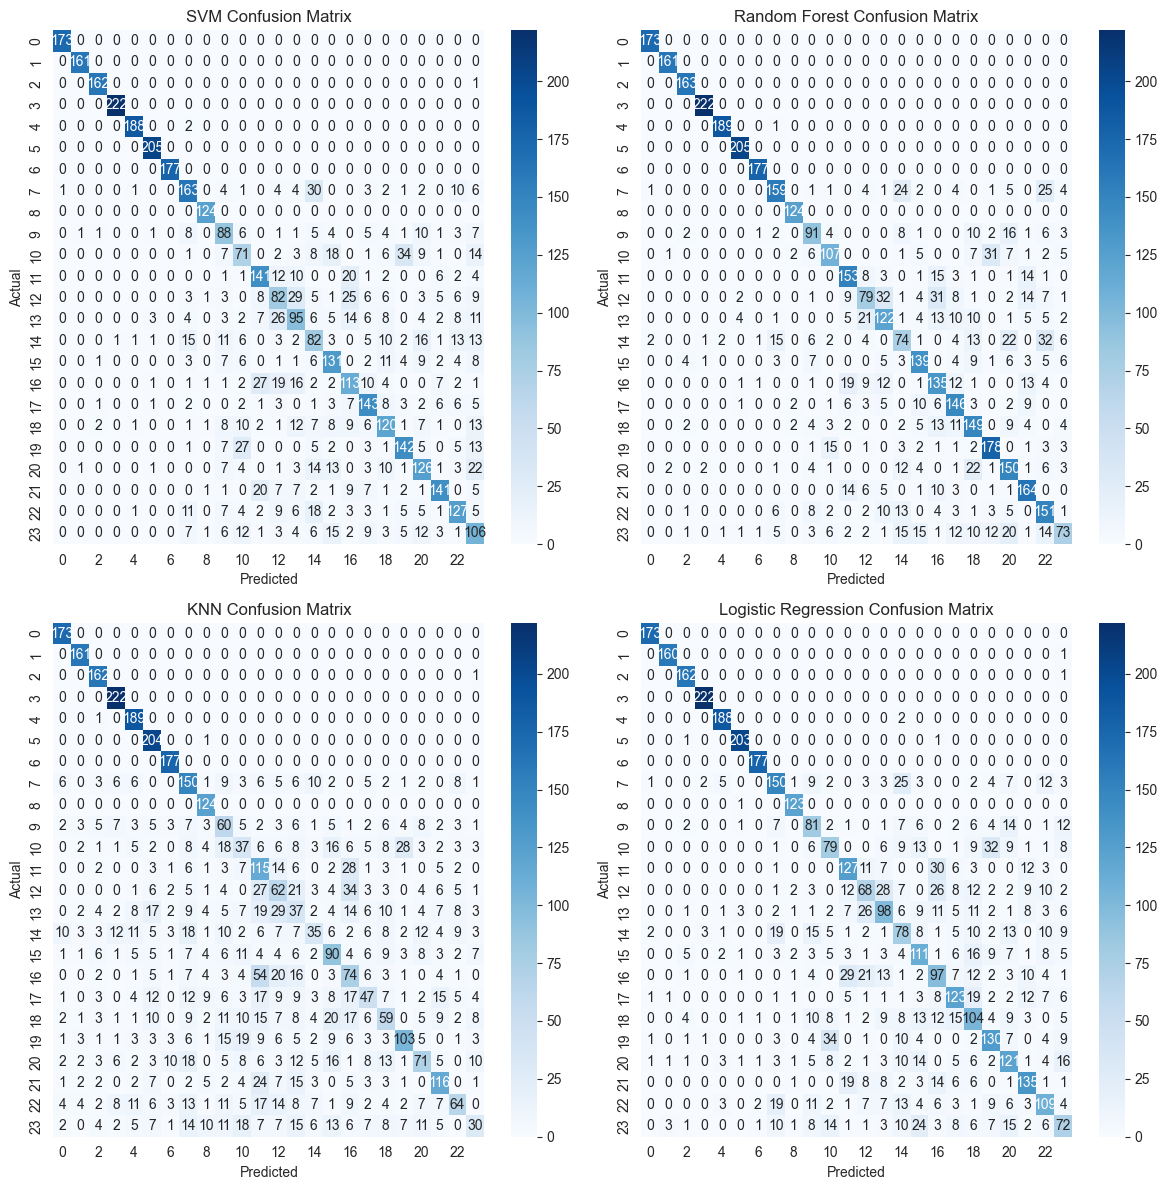

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

models = {
    "SVM": svm_pred,
    "Random Forest": rf_pred,
    "KNN": knn_pred,
    "Logistic Regression": log_pred
}

plt.figure(figsize=(12, 12))

i = 1
for name, pred in models.items():
    plt.subplot(2, 2, i)
    cm = confusion_matrix(y_test, pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    i += 1

plt.tight_layout()
plt.show()



-------------------------------------------------------------
SECTION 9B — COMPARISON ALL MODELS
-------------------------------------------------------------


MODEL COMPARISON:
SVM: 71.51%
Random Forest: 75.89%
KNN: 55.80%
Logistic Regression: 67.33%


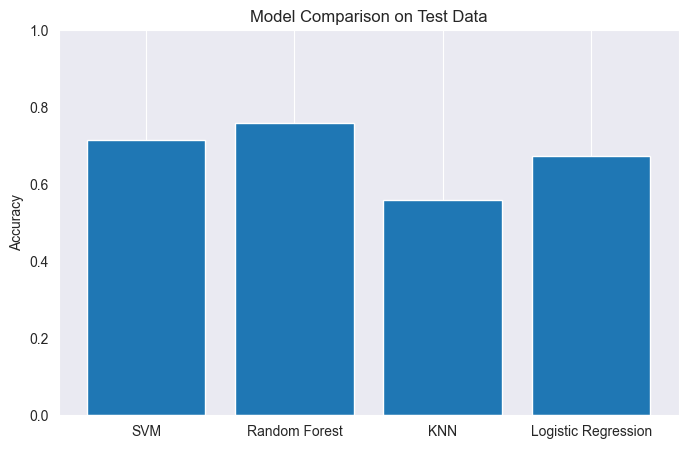

In [49]:
model_names = ["SVM", "Random Forest", "KNN", "Logistic Regression"]

accuracies = [
    accuracy_score(y_test, svm_pred),
    accuracy_score(y_test, rf_pred),
    accuracy_score(y_test, knn_pred),
    accuracy_score(y_test, log_pred),
]

print("\nMODEL COMPARISON:")
for name, acc in zip(model_names, accuracies):
    print(f"{name}: {acc * 100:.2f}%")

plt.figure(figsize=(8, 5))
plt.bar(model_names, accuracies)
plt.ylabel("Accuracy")
plt.title("Model Comparison on Test Data")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()



-------------------------------------------------------------
SECTION 10 — CROSS VALIDATION (10-Fold)
-------------------------------------------------------------


10-FOLD CROSS VALIDATION RESULTS:

SVM (RBF):
  Fold Accuracies: [0.703 0.725 0.71  0.727 0.715 0.707 0.706 0.718 0.719 0.727]
  Mean Accuracy: 71.57%

Random Forest:
  Fold Accuracies: [0.758 0.767 0.746 0.766 0.75  0.746 0.773 0.764 0.757 0.761]
  Mean Accuracy: 75.88%

KNN:
  Fold Accuracies: [0.537 0.553 0.546 0.54  0.552 0.547 0.545 0.547 0.545 0.55 ]
  Mean Accuracy: 54.62%

Logistic Regression:
  Fold Accuracies: [0.658 0.68  0.686 0.686 0.68  0.662 0.667 0.673 0.683 0.683]
  Mean Accuracy: 67.57%



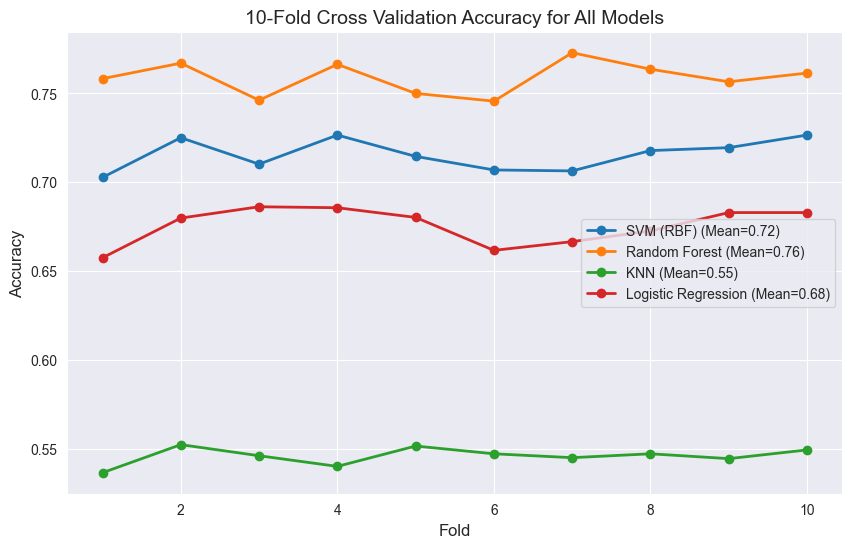

In [54]:
from sklearn.model_selection import cross_val_score
import numpy as np
import matplotlib.pyplot as plt

models_cv = {
    "SVM (RBF)": svm_model,
    "Random Forest": rf_model,
    "KNN": knn_model,
    "Logistic Regression": log_model
}

k = 10
cv_scores = {}   # store fold-wise CV scores

print("\n10-FOLD CROSS VALIDATION RESULTS:\n")

for name, model in models_cv.items():

    # Random Forest uses unscaled features
    if name == "Random Forest":
        scores = cross_val_score(model, X_train_features, y_train, cv=k)
    else:
        scores = cross_val_score(model, X_train_scaled, y_train, cv=k)

    cv_scores[name] = scores  # save results

    print(f"{name}:")
    print("  Fold Accuracies:", np.round(scores, 3))
    print(f"  Mean Accuracy: {scores.mean() * 100:.2f}%\n")


# -------------------------------
# Visualization for ALL MODELS
# -------------------------------
plt.figure(figsize=(10, 6))

for name, scores in cv_scores.items():
    plt.plot(range(1, k + 1), scores,
             marker='o', linewidth=2, label=f"{name} (Mean={scores.mean():.2f})")

plt.title("10-Fold Cross Validation Accuracy for All Models", fontsize=14)
plt.xlabel("Fold", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.grid(True)
plt.legend()
plt.show()


-------------------------------------------------------------
SECTION 11 — SAMPLE PREDICTIONS
-------------------------------------------------------------

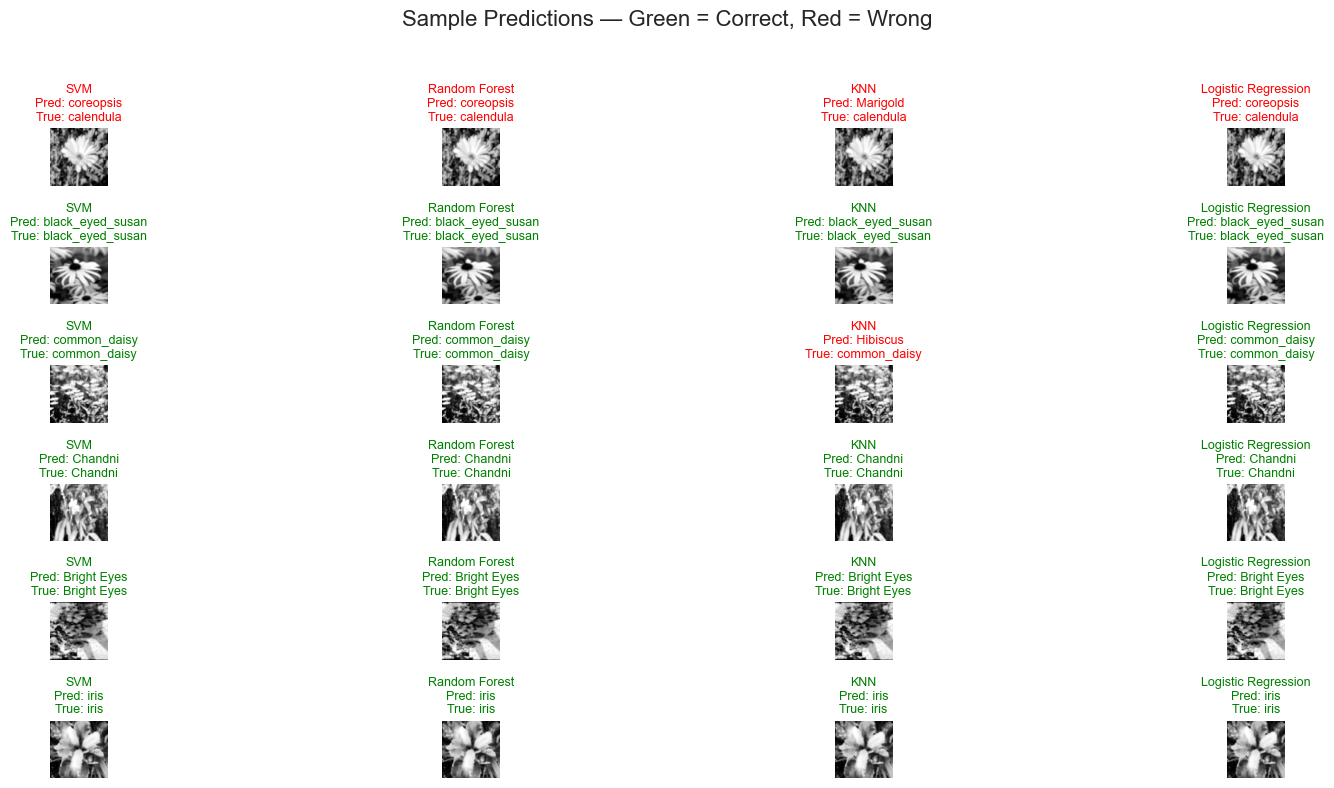

In [46]:
#    SECTION 11 — SAMPLE PREDICTIONS(ALL MODELS)
#-------------------------------------------------------------

models = {
    "SVM": svm_pred,
    "Random Forest": rf_pred,
    "KNN": knn_pred,
    "Logistic Regression": log_pred
}

num_samples = 6  # Number of test images to display

plt.figure(figsize=(18, 8))

for i in range(num_samples):
    for j, (name, pred) in enumerate(models.items()):
        plt.subplot(num_samples, len(models), i * len(models) + j + 1)
        plt.imshow(X_test_gray[i], cmap='gray')
        color = "green" if pred[i] == y_test[i] else "red"
        plt.title(f"{name}\nPred: {pred[i]}\nTrue: {y_test[i]}", color=color, fontsize=9)
        plt.axis('off')

plt.suptitle("Sample Predictions — Green = Correct, Red = Wrong", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()



-------------------------------------------------------------
SECTION 13 — SAVE MODEL & SCALER
-------------------------------------------------------------

In [47]:
#  SECTION 14 — SAVE ALL MODELS & SCALER
# -------------------------------------------------------------

save_path = r"C:\Users\DELL\Desktop\models"
os.makedirs(save_path, exist_ok=True)

# Save models
joblib.dump(svm_model, os.path.join(save_path, "svm_flower_model.pkl"))
joblib.dump(rf_model, os.path.join(save_path, "rf_flower_model.pkl"))
joblib.dump(knn_model, os.path.join(save_path, "knn_flower_model.pkl"))
joblib.dump(log_model, os.path.join(save_path, "logreg_flower_model.pkl"))

# Save scaler
joblib.dump(scaler, os.path.join(save_path, "scaler.pkl"))

print("\nAll models and scaler saved successfully.")





All models and scaler saved successfully.
